Load the data

In [24]:
import torch
import os
from torch import nn, optim, argmax, Tensor
from torchmetrics.classification import Accuracy, MulticlassConfusionMatrix
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.utilities.model_summary import ModelSummary
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [26]:
training_data = MNIST(
    root = './data/',
    train = True,
    download = True,
    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,))
    ])
),

testing_data = MNIST(
    root = './data/',
    train = False,
    download = True,
    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,))
    ]),
),

Note: Images are retrieved using training_data[0].data and labels with training_data[0].targets

In [27]:
training_data[0].data.shape

torch.Size([60000, 28, 28])

i.e. there are 60k images of size 28x28

How do I know which values to use to normalize?

In [28]:
print(training_data[0].data.float().mean()/255)
print(training_data[0].data.float().std()/255)

tensor(0.1307)
tensor(0.3081)


Let's visualize the first 9 images

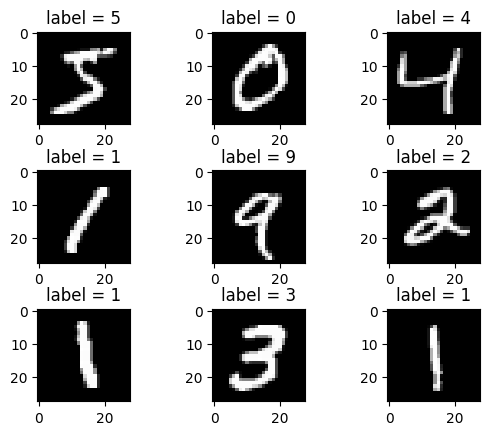

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
for i in range(9):
    ax[i].imshow(training_data[0].data[i], cmap='gray')
    ax[i].set_title(f'label = {training_data[0].targets[i]}')
plt.subplots_adjust(hspace=0.5)
plt.show()

Split train data into training and validation

In [30]:
# Split training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(training_data[0].data, training_data[0].targets, test_size=0.2, random_state=10)
validation_data = deepcopy(training_data)
validation_data[0].data = Tensor(X_val)
validation_data[0].targets = Tensor(y_val)
training_data[0].data = Tensor(X_train)
training_data[0].targets = Tensor(y_train)

Now create Data Loaders

In [31]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dict: dict, batch_size_dict: dict):
        super().__init__()
        self.data_dict = data_dict
        self.batch_size_dict = batch_size_dict

    def train_dataloader(self):
        return DataLoader(
            self.data_dict['training'],
            batch_size = self.batch_size_dict['training'],
            shuffle = True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.data_dict['testing'],
            batch_size = self.batch_size_dict['testing'],
            shuffle = False  # so I can easily track labels-predictions
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.data_dict['validation'],
            batch_size = self.batch_size_dict['validation'],
            shuffle = True
        )

## Let's create our model

The shape of our input data is: 1, 28, 28 [in_channels, #pixels, #pixel]

Note: in_channels (input channels) is 1 becacuse I'm using grayscale images

Our first layer will apply a 2D convolution over the input data using the Conv2d function:

```
Conv2d(in_channels, out_channels, kernel_size)
```
Note: all other arguments are left to their default values (i.e., stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

We can use the following formula to know the shape of the resulting image about the 2D convolution:

shape = out, out, out_channels

where
```
out = [#pixels + 2 * padding - kernel_size ] / stride + 1
```

In this case, it gives us the following shape:

26, 26, 32

The 2D convolution will be followed by a ReLU activation function.

The 2nd layer will be again applying a 2D convolution (+ReLU) but this time I will be applying a 2D max pooling technique (to reduce the number of trainable parameters) followed by a dropout layer (with a probability of 0.25):

```
Conv2d(32, 64, kernel_size_3) + MaxPool2d(2) + Dropout(2)
```

To know the shape of the second layer, we use the same formula above but divide out by 2 (due to pooling), which will give us: 12, 12, 64

After flattening, there will be two Linear layers where the number of input features on the first layer will be 12 * 12 * 64.

Conv2d(in_channels, out_channels, kernel_size)
In the  1st Conv2d, I set in_channels to 1 because I'm using grayscale images
out_channels is arbitrary




Formula

In [32]:
class Model(pl.LightningModule):
    def __init__(self, k):
        super().__init__()
        # Set list of layers in the model
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3),
            torch.nn.ReLU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.25)
        )
        self.fc1 = torch.nn.Linear(64 * 12 * 12 , 128)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5)
        )
        self.fc2 = torch.nn.Linear(128, k)
        self.layer4 = torch.nn.Sequential(
           self.fc2,
        )
        # Define other attributes
        self.loss = nn.CrossEntropyLoss()
        self.lr = 0.001
        self.accuracy = Accuracy(task="multiclass", num_classes=k)
        self.test_pred = []  # collect predictions
        self.pred_pred = []  # collect predictions
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=k)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # flatten
        out = self.layer3(out)
        out = self.layer4(out)
        return out
   
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('loss', loss)
        # Track accuracy
        y_pred = argmax(logits, dim=-1)
        acc = self.accuracy(y_pred, y)
        self.log('accuracy', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss)
        # Track accuracy
        y_pred = argmax(logits, dim=-1)
        acc = self.accuracy(y_pred, y)
        self.log('val_accuracy', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # Evaluate model
        logits = self.forward(x)
        # Track loss
        loss = self.loss(logits, y)
        self.log('test_loss', loss)
        # Track accuracy
        y_pred = argmax(logits, dim=-1)  # find label with highest probability
        acc = self.accuracy(y_pred, y)
        self.log('test_accuracy', acc)
        # Collect predictions
        self.test_pred.extend(y_pred.cpu().numpy())
        # Update confusion matrix
        self.confusion_matrix.update(y_pred, y)

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        logits = self.forward(x)
        y_pred = argmax(logits, dim=-1)
        # Collect predictions
        self.pred_pred.extend(y_pred.cpu().numpy())
        return y_pred

In [33]:
# Figure out the number of classes
k = len(torch.unique(training_data[0].targets))
# Create model
model = Model(k=k)
summary = ModelSummary(model, max_depth=-1)
print(summary)

   | Name             | Type                      | Params
----------------------------------------------------------------
0  | layer1           | Sequential                | 320   
1  | layer1.0         | Conv2d                    | 320   
2  | layer1.1         | ReLU                      | 0     
3  | layer2           | Sequential                | 18.5 K
4  | layer2.0         | Conv2d                    | 18.5 K
5  | layer2.1         | ReLU                      | 0     
6  | layer2.2         | MaxPool2d                 | 0     
7  | layer2.3         | Dropout                   | 0     
8  | fc1              | Linear                    | 1.2 M 
9  | layer3           | Sequential                | 1.2 M 
10 | layer3.1         | ReLU                      | 0     
11 | layer3.2         | Dropout                   | 0     
12 | fc2              | Linear                    | 1.3 K 
13 | layer4           | Sequential                | 1.3 K 
14 | loss             | CrossEntropyLoss          

In [34]:
class MetricTrackerCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.losses = {
            'loss': [],
            'val_loss': []
        }
        self.acc = {
            'accuracy': [],
            'val_accuracy': []
        }

    def on_train_epoch_end(self, trainer, module):
        metrics = trainer.logged_metrics
        self.losses['loss'].append(metrics['loss'])
        self.acc['accuracy'].append(metrics['accuracy'])

    def on_validation_epoch_end(self, trainer, module):
        metrics = trainer.logged_metrics
        self.losses['val_loss'].append(metrics['val_loss'])
        self.acc['val_accuracy'].append(metrics['val_accuracy'])

In [35]:
# Create a PyTorch Lightning trainer and add callbacks
tracker = MetricTrackerCallback()
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    min_delta = 0.001,
    mode = 'min',
)
from pathlib import Path
dirpath = Path.cwd()
# Remove previous best model (if exists)
if os.path.exists('best_model.ckpt'):
    os.remove('best_model.ckpt')
model_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath = dirpath,
    filename = "best_model",
    monitor = 'val_loss',
    save_top_k = 1,
    mode = 'min',
)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(
    max_epochs = 10,
    enable_model_summary = False,  # summary printed already
    callbacks = [
        tracker,
        early_stopping_callback,
        model_checkpoint_callback
    ],
    accelerator = accelerator,
    num_sanity_val_steps = 0,  # turn off sanity check
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [52]:
import copy
# Create an instance of the data module
data_dict = {
    'training': training_data[0],
    'validation': validation_data[0],
    'testing': testing_data[0],
}

batch_size_dict = {
    'training': 32,
    'validation': 32,
    'testing': 128,
}
data_module = DataModule(data_dict=data_dict, batch_size_dict=batch_size_dict)

## Let's train the model

In [37]:
# Train the model
trainer.fit(model, data_module)

c:\Users\bossi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:630: Checkpoint directory c:\JONA\ContentCreation\Python\CNN-Image-Classifier-PyTorch-Lightning-MNIST exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\bossi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\bossi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\bossi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connect

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Let's plot the metrics (loss and accuracy)

In [38]:
def plot_loss(loss_dict) -> None:
    """ Plot loss and val_loss """
    # Get losses
    if torch.cuda.is_available():
        losses = [loss_dict['loss'][i].cpu() for i in range(len(loss_dict['loss']))]
        val_losses = [loss_dict['val_loss'][i].cpu() for i in range(len(loss_dict['val_loss']))]
    else:
        losses = loss_dict['loss']
        val_losses = loss_dict['val_loss']
    # Plot them
    plt.figure('loss')
    plt.plot(losses, label='loss', c='black')
    plt.plot(val_losses, label='val_loss', c='red')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    # plt.savefig('loss.png')
    plt.show()

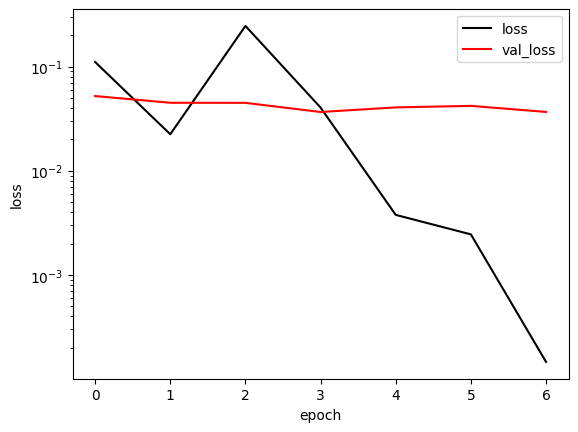

In [39]:
plot_loss(tracker.losses)  # plot loss vs epoch

In [40]:
def plot_accuracy(acc_dict) -> None:
    """ Plot accuracy and val_accuracy """
    # Get accuracy values
    if torch.cuda.is_available():
        accuracy = [acc_dict['accuracy'][i].cpu() for i in range(len(acc_dict['accuracy']))]
        val_accuracy = [acc_dict['val_accuracy'][i].cpu() for i in range(len(acc_dict['val_accuracy']))]
    else:
        accuracy = acc_dict['accuracy']
        val_accuracy = acc_dict['val_accuracy']
    # Plot them
    plt.figure('accuracy')
    plt.plot(accuracy, label='accuracy', c='black')
    plt.plot(val_accuracy, label='val_accuracy', c='red')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    # plt.savefig('accuracy.png')
    plt.show()

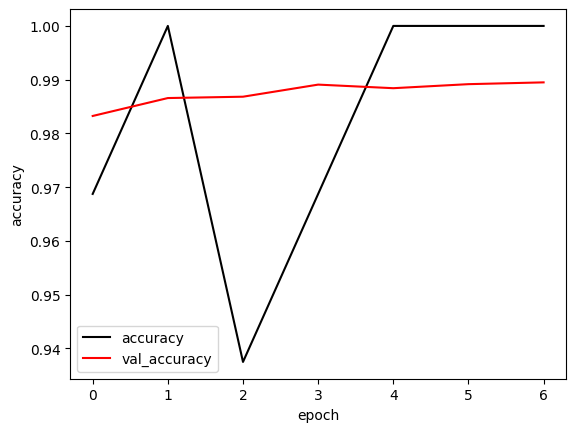

In [41]:
plot_accuracy(tracker.acc)  # plot accuracy vs epoch

## Let's evaluate the performance on test data

If I do the following:
```
result = trainer.test(model, data_module, verbose=False)
```
I will use the model at the last epoch

Instead, I should do any of the following

#1: tell to use the best model
```
result = trainer.test(model, data_module, verbose=False, ckpt_path="best")
```

#2: load best model
```
model = Model.load_from_checkpoint('best_model.ckpt', k=k)
result = trainer.test(model, data_module, verbose=False)
```

#3: provide file with best model
```
result = trainer.test(model, data_module, verbose=False, ckpt_path="best_model.ckpt")
```

In [53]:
result = trainer.test(model, data_module, verbose=False, ckpt_path="best_model.ckpt")
print(f"Accuracy in test data: {result[0]['test_accuracy']}")
print(f"Loss in test data: {result[0]['test_loss']}")

Restoring states from the checkpoint path at best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at best_model.ckpt
c:\Users\bossi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Accuracy in test data: 0.9893999695777893
Loss in test data: 0.03016902133822441


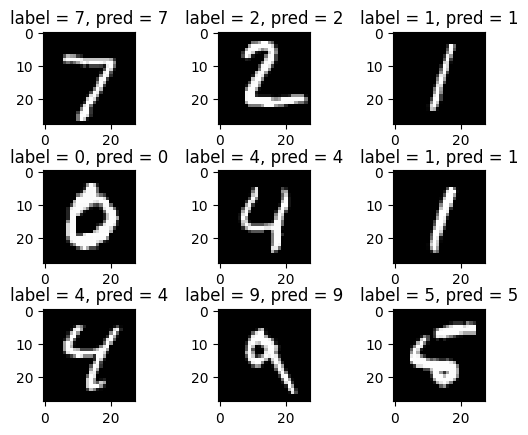

In [43]:
# Visualize some test images and model's predictions
import matplotlib.pyplot as plt
fig, ax = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
for i in range(9):
    ax[i].imshow(testing_data[0].data[i], cmap='gray')
    ax[i].set_title(f'label = {testing_data[0].targets[i]}, pred = {model.test_pred[i]}')
plt.subplots_adjust(hspace=0.5)
plt.show()

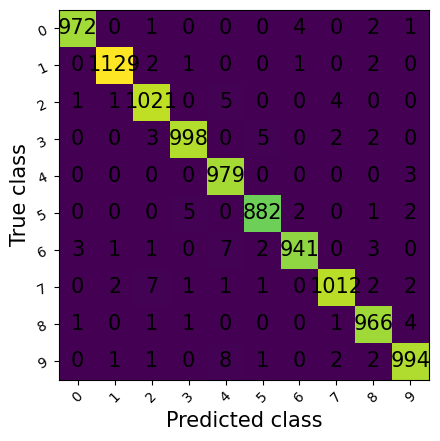

In [44]:
# Plot confusion matrix
fig, _ = model.confusion_matrix.plot()

## How to get predictions?

In [54]:
class PDataModule(pl.LightningDataModule):
    def __init__(self, data, batch_size):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
    
    def predict_dataloader(self):
        return DataLoader(
            self.data,
            batch_size = self.batch_size,
            shuffle = False
        )

data_module = PDataModule(testing_data[0], 128)
_ = trainer.predict(model, datamodule=data_module, ckpt_path='best_model.ckpt')

Restoring states from the checkpoint path at best_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at best_model.ckpt
c:\Users\bossi\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [46]:
print(model.pred_pred)

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 7, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 